# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 19 July 2020

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.
- (Also, because I've just slapped this together in a
few hours + re-learning how to use pandas/matplotlib,
so i haven't put together a way to quickly
compare % change across many more slices of data -- see todo)

## todo

- helper functions to dry code
- plot graph that shows week-on-week daily % increase
- plot that graph for every week since beginning of data

In [198]:
import pandas as pd
import os
from matplotlib.pyplot import grid,plot,barh,xticks,yticks,legend
import numpy as np

_DATADIR="../_data"

# There are two datasets
# _DATA_CASES is a CSV file containing data on nationally reported cases
# _DATA_CUMUL contains data on cumulative infections, hospitalizations, deaths
#_DATA_CASES="COVID-19_casus_landelijk.csv"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2020-07-24.csv"

#cases = pd.read_csv(os.path.join(_DATADIR, _DATA_CASES), delimiter=";")
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")

# set dtype of "Date_of_report" to pd.DatetimeTZDtype
# get date in YYYY-MM-DD by accessing
# cumul_ams["Date_of_report"].dt.date
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"])
cumul.info()

cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)
cumul["Date_of_report"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49178 entries, 0 to 49177
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      49178 non-null  datetime64[ns]
 1   Municipality_code   47570 non-null  object        
 2   Municipality_name   47570 non-null  object        
 3   Province            49178 non-null  object        
 4   Total_reported      49178 non-null  int64         
 5   Hospital_admission  49178 non-null  int64         
 6   Deceased            49178 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.6+ MB


0       2020-03-13
250     2020-03-13
249     2020-03-13
248     2020-03-13
247     2020-03-13
           ...    
48928   2020-07-24
48927   2020-07-24
48926   2020-07-24
48935   2020-07-24
49177   2020-07-24
Name: Date_of_report, Length: 49178, dtype: datetime64[ns]

In [170]:
# NOT USED YET
#cases_ams = cases[cases["Municipal_health_service"].isin(["GGD Amsterdam"])]
#cases_ams.tail()

We want only cases from Amsterdam:

In [171]:
cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

In [172]:
# create new column for day of week
cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name())
cumul_ams["Day"].astype("str")

109         Friday
476       Saturday
843         Sunday
1210        Monday
1577       Tuesday
           ...    
47452       Monday
47819      Tuesday
48186    Wednesday
48553     Thursday
48920       Friday
Name: Day, Length: 134, dtype: object

In [173]:
# create new column for week number
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week)
cumul_ams["Week"]

109      11
476      11
843      11
1210     12
1577     12
         ..
47452    30
47819    30
48186    30
48553    30
48920    30
Name: Week, Length: 134, dtype: int64

In [174]:
cumul_ams["Deceased"][-30:]

38277    284
38644    284
39011    284
39378    284
39745    284
40112    284
40479    284
40846    284
41213    284
41580    284
41947    284
42314    284
42681    284
43048    284
43415    284
43782    284
44149    284
44516    284
44883    284
45250    284
45617    284
45984    284
46351    284
46718    282
47085    282
47452    282
47819    282
48186    282
48553    282
48920    282
Name: Deceased, dtype: int64

In [175]:
# create working df with only 3 cols:
# date, cumulative reports, day of week

cumuldf = cumul_ams[["Date_of_report","Day","Week","Total_reported"]]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 109 to 48920
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date_of_report  134 non-null    datetime64[ns]
 1   Day             134 non-null    object        
 2   Week            134 non-null    int64         
 3   Total_reported  134 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.2+ KB


In [176]:
# compare day on day increments

def get_daily_delta(df):
    daily_delta_column = []
    rep = df["Total_reported"]
    for i in range(0,len(df["Total_reported"])):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(rep.iloc[i]-rep.iloc[i-1])

    return daily_delta_column

daily_delta = get_daily_delta(cumuldf)
cumuldf.insert(len(cumuldf.columns),"Daily_delta",daily_delta)

In [177]:
cumuldf.tail()

,Date_of_report,Day,Week,Total_reported,Daily_delta
47452,2020-07-20,Monday,30,2852,28
47819,2020-07-21,Tuesday,30,2873,21
48186,2020-07-22,Wednesday,30,2891,18
48553,2020-07-23,Thursday,30,2906,15
48920,2020-07-24,Friday,30,2925,19


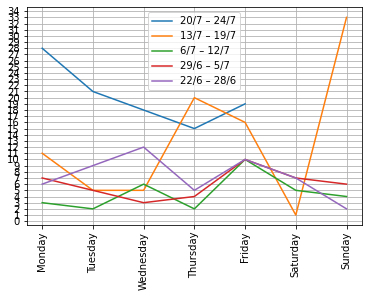

In [178]:
def plot_daily_delta_for_last_n_weeks(df, n=3):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart

    :param df:
    :type df: pandas.DataFrame
    :param n: Last n weeks
    :type n: int
    :return: None
    """
    grid(True)
    xticks(rotation="vertical")
    yticks(np.arange(0, df["Daily_delta"].max(), step=1))

    for week in range(0,n):
        df_week = df["Week"]
        this_week = df[df_week == df_week.max()-week]
        week_start = this_week.iloc[0]["Date_of_report"]
        week_start_d_m = f"{week_start.day}/{week_start.month}"
        week_end = this_week.iloc[-1]["Date_of_report"]
        week_end_d_m = f"{week_end.day}/{week_end.month}"

        plot(this_week["Day"],this_week["Daily_delta"],label=f"{week_start_d_m} – {week_end_d_m}")
    legend()

plot_daily_delta_for_last_n_weeks(cumuldf, 5)

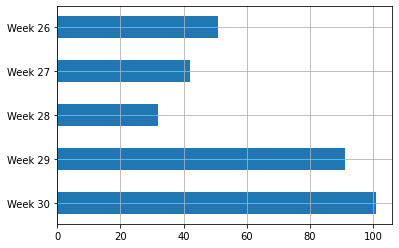

In [209]:
def plot_weekly_delta_for_last_n_weeks(df, n):
    """
    Plot the weekly delta for the last n weeks

    :param df: dataframe
    :type df: pandas.DataFrame
    :param n: Last n weeks
    :type n: int
    :return: None
    """
    grid(True)
    weekly_delta = {}
    for week in range(0,n):
        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()
        weekly_delta[f"Week {this_week_num}"] = week_delta

    barh(list(weekly_delta.keys()), width=np.array(list(weekly_delta.values())),height=0.5)


plot_weekly_delta_for_last_n_weeks(cumuldf, 5)

## Cumulative reported cases for the last 30 days

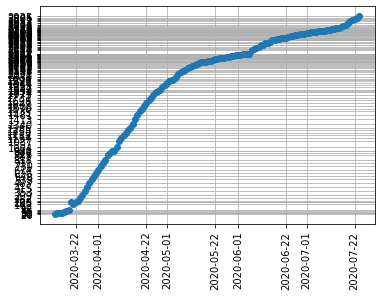

In [179]:
# figure for last 30 days
cumul_ams_dates = cumuldf["Date_of_report"].loc[-30:,]
cumul_ams_reported = cumuldf["Total_reported"].loc[-30:,]

from matplotlib.pyplot import plot_date

grid(True)
xticks(rotation="vertical")
yticks(cumul_ams_reported)
plot_date(cumul_ams_dates, cumul_ams_reported,xdate=True )

In [180]:
# get current week
current_week = cumuldf["Week"].max()

# get slice for current week
week_this = cumuldf[cumuldf["Week"] == current_week]
week_last = cumuldf[cumuldf["Week"] == (current_week-1)]
week_last2 = cumuldf[cumuldf["Week"] == (current_week-2)]
week_last3 = cumuldf[cumuldf["Week"] == (current_week-3)]

week_last3

,Date_of_report,Day,Week,Total_reported,Daily_delta
39745,2020-06-29,Monday,27,2666,7
40112,2020-06-30,Tuesday,27,2671,5
40479,2020-07-01,Wednesday,27,2674,3
40846,2020-07-02,Thursday,27,2678,4
41213,2020-07-03,Friday,27,2688,10
41580,2020-07-04,Saturday,27,2695,7
41947,2020-07-05,Sunday,27,2701,6


In [181]:

second_last_day_of_week = week_this[-1:]["Date_of_report"]-np.timedelta64(1,"D")


# cumul_ams[cumul_ams["Date_of_report"].isin(second_last_day_of_week)]

In [182]:
# reported figures for each week
cumul_ams_dates_last7 = cumul_ams["Date_of_report"][-7:]
cumul_ams_reported_last7 = cumul_ams["Total_reported"][-7:]
cumul_ams_dates_prev7 = cumul_ams["Date_of_report"][-14:-7]
cumul_ams_reported_prev7 = cumul_ams["Total_reported"][-14:-7]
cumul_ams_dates_3weeks = cumul_ams["Date_of_report"][-21:-14]
cumul_ams_reported_3weeks = cumul_ams["Total_reported"][-21:-14]

# format dates so we can overlay the plots
import datetime

cumul_ams_dates_last7_dt = cumul_ams_dates_last7.dt.date
cumul_ams_dates_prev7_dt = cumul_ams_dates_prev7.dt.date
cumul_ams_dates_3weeks_dt = cumul_ams_dates_3weeks.dt.date

concat_dates = []
for i in range(0,7):
    concat_dates.append(f"{cumul_ams_dates_last7_dt.to_list()[i]}/{cumul_ams_dates_prev7_dt.to_list()[i]}/{cumul_ams_dates_3weeks_dt.to_list()[i]}")

# days = ["Monday","Tuesday","Wednesday","Thursday","Friday", "Saturday", "Sunday"]
cumul_ams_dates_last7_dt

46718    2020-07-18
47085    2020-07-19
47452    2020-07-20
47819    2020-07-21
48186    2020-07-22
48553    2020-07-23
48920    2020-07-24
Name: Date_of_report, dtype: object

## Overlaying reported cases for last 21 days

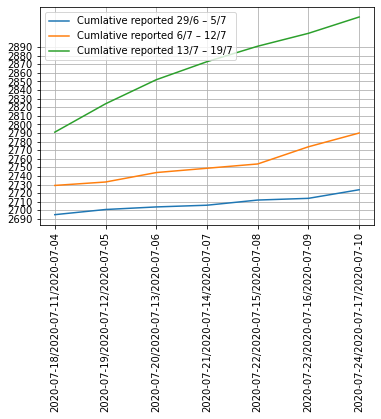

In [183]:
grid(True)
xticks(np.arange(0,7,step=1),rotation="vertical")
yticks(np.arange(1000,2900,step=10))
plot(concat_dates, cumul_ams_reported_3weeks,label="Cumlative reported 29/6 – 5/7")
plot(concat_dates, cumul_ams_reported_prev7, label="Cumlative reported 6/7 – 12/7")
plot(concat_dates, cumul_ams_reported_last7, label="Cumlative reported 13/7 – 19/7")

legend()

Last week's numbers

In [184]:
tmp_df = cumul_ams[["Date_of_report","Total_reported"]]
last7 = tmp_df[-8:]
last7

,Date_of_report,Total_reported
46351,2020-07-17,2790
46718,2020-07-18,2791
47085,2020-07-19,2824
47452,2020-07-20,2852
47819,2020-07-21,2873
48186,2020-07-22,2891
48553,2020-07-23,2906
48920,2020-07-24,2925


In [185]:
last7_reported = last7["Total_reported"].to_list()
last7_daily_incrm = []
for i in range(0,len(last7_reported)):
    if i >0:
        last7_daily_incrm.append(
            last7_reported[i]-last7_reported[i-1]
            )

last7_daily_incrm

[1, 33, 28, 21, 18, 15, 19]

So we can see that last week's numbers:

- Increased from 2744 to 2824 -- +80
-

### Previous week's numbers

In [186]:
tmp_df[-15:-7]

,Date_of_report,Total_reported
43782,2020-07-10,2724
44149,2020-07-11,2729
44516,2020-07-12,2733
44883,2020-07-13,2744
45250,2020-07-14,2749
45617,2020-07-15,2754
45984,2020-07-16,2774
46351,2020-07-17,2790


In [187]:
prev7_reported = tmp_df["Total_reported"][-15:-7].to_list()
prev7_daily_incrm = []
for i in range(0,len(prev7_reported)):
    if i >0:
        prev7_daily_incrm.append(
            prev7_reported[i]-prev7_reported[i-1]
            )

prev7_daily_incrm

[5, 4, 11, 5, 5, 20, 16]

In [188]:
last3weeks = tmp_df[-22:-14]

last3weeks_reported = last3weeks["Total_reported"].to_list()
last3weeks_daily_incrm = []
for i in range(0,len(last3weeks_reported)):
    if i >0:
        last3weeks_daily_incrm.append(
            last3weeks_reported[i]-last3weeks_reported[i-1]
            )

last3weeks_daily_incrm

[7, 6, 3, 2, 6, 2, 10]

### Daily increase in cases, week on week:

In [189]:
week_on_week_incrm_percent = []
for i in range(0,len(prev7_daily_incrm)):
    week_on_week_incrm_percent.append(
        last7_daily_incrm[i]/prev7_daily_incrm[i]*100
    )

week_on_week_incrm_percent

[20.0, 825.0, 254.54545454545453, 420.0, 360.0, 75.0, 118.75]

### 3 weeks ago vs last week

In [190]:
week_on_week_incrm_percent_3weeks = []
for i in range(0,len(prev7_daily_incrm)):
    week_on_week_incrm_percent_3weeks.append(
        prev7_daily_incrm[i]/last3weeks_daily_incrm[i]*100
    )

week_on_week_incrm_percent_3weeks

[71.42857142857143,
 66.66666666666666,
 366.66666666666663,
 250.0,
 83.33333333333334,
 1000.0,
 160.0]

### Plot daily increase for 3 weeks

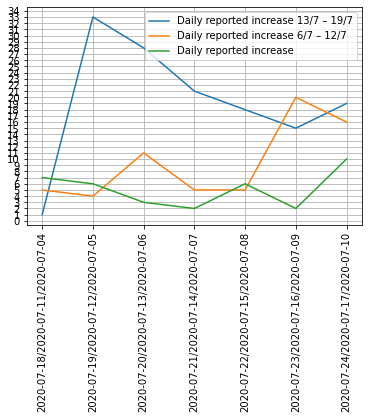

In [191]:
grid()
xticks(np.arange(0,7,step=1),rotation="vertical")
yticks(np.arange(0,40,step=1))
plot(concat_dates,last7_daily_incrm,label="Daily reported increase 13/7 – 19/7")
plot(concat_dates,prev7_daily_incrm,label="Daily reported increase 6/7 – 12/7")
plot(concat_dates,last3weeks_daily_incrm, label="Daily reported increase ")
legend()

### Total reported cases increase, week on week:

In [192]:
sum(last7_daily_incrm)/sum(prev7_daily_incrm)*100

204.54545454545453

In [193]:
sum(prev7_daily_incrm)/sum(last3weeks_daily_incrm)*100

183.33333333333331